In [432]:
import os
import pandas as pd
from datetime import datetime, timedelta

In [433]:
train_file = 'train_data.csv'
test_file = 'test_data.csv'

data_path = '/opt/ml/input/data/train_dataset'
train_path = os.path.join(data_path, train_file)
test_path = os.path.join(data_path, test_file)

In [434]:
train_df = pd.read_csv(train_path, parse_dates=['Timestamp'])
test_df = pd.read_csv(test_path, parse_dates=['Timestamp'])

### 1) test set의 모든 userID가 train set에는 없다

In [4]:
result = test_df['userID'].isin(train_df['userID'].unique())
all(~result)

True

### 2) test set의 assessmentItemID(=testId=KnowledgeTag) 는 모두 train set에 존재한다

In [5]:
result = test_df['assessmentItemID'].isin(train_df['assessmentItemID'].unique())
print(all(result))
result = test_df['testId'].isin(train_df['testId'].unique())
print(all(result))
result = test_df['KnowledgeTag'].isin(train_df['KnowledgeTag'].unique())
print(all(result))

True
True
True


### 3) userID 마다 answerCode가 -1 인 row가 하나뿐이다. -1 은 마지막 timestamp를 갖는다

In [6]:
unique_id = len(test_df['userID'].unique())
minus_len = len(test_df[test_df['answerCode'] == -1])
minus_unique_id = len(test_df[test_df['answerCode'] == -1]['userID'].unique())

print(unique_id, minus_len, minus_unique_id, )

744 744 744


### 4) test set내 unique 개수

In [7]:
minus_df = test_df[test_df['answerCode'] == -1]

In [8]:
unique_assessment = minus_df['assessmentItemID'].unique()
unique_test = minus_df['testId'].unique()
unique_tag = minus_df['KnowledgeTag'].unique()
print(unique_assessment.size)
print(unique_test.size)
print(unique_tag.size)

444
411
273


### 5) 마지막 문제와 같은 문제를 푼 기록이 있기도 하다

In [226]:
minus_question = minus_df[['userID', 'assessmentItemID']].values

In [246]:
for uid, itemid in minus_question:
    res = test_df[(test_df['userID'] == uid) & (test_df['assessmentItemID'] == itemid)]
    if len(res) > 1:
        print(uid, itemid)

203 A060073007
1268 A010135005
1362 A070120008
1469 A070163008
1805 A010149005
1885 A040135004
2171 A020147004
2334 A090049006
3465 A040146005
3716 A080128011
4144 A080123008
6027 A030131005


In [392]:
test_df[(test_df['userID'] == 203) & (test_df['assessmentItemID'] == 'A060073007')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
16212,203,A060073007,A060000073,1,2020-07-30 10:25:26,616
16728,203,A060073007,A060000073,-1,2020-10-23 10:00:55,616


In [396]:
group_test[(group_test['userID'] == 203) & (group_test['assessmentItemID'] == 'A060073007')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
16212,203,A060073007,A060000073,1,2020-07-30 10:25:26,616,NaT
16728,203,A060073007,A060000073,-1,2020-10-23 10:00:55,616,NaT


In [402]:
train_elapse = train_df.groupby(['userID', 'testId']).apply(calculate_elapse)

KeyboardInterrupt: 

* apply() too slow

In [418]:
train_df['tmp_index'] = train_df.index

In [424]:
time = train_df[['userID', 'tmp_index', 'Timestamp']]

In [425]:
time['tmp_index'] = time['tmp_index']+1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [428]:
train_elapse = train_df.merge(time, how='left', on=['userID', 'tmp_index'])

In [430]:
train_elapse['elapse'] = train_elapse['Timestamp_x'] - train_elapse['Timestamp_y']

In [431]:
train_elapse[train_elapse['assessmentItemID'] == 'A060073007']

,userID,assessmentItemID,testId,answerCode,Timestamp_x,KnowledgeTag,tmp_index,Timestamp_y,elapse
4690,8,A060073007,A060000073,0,2020-05-13 12:11:53,616,4690,2020-05-13 12:10:16,0 days 00:01:37
27042,36,A060073007,A060000073,0,2020-08-25 01:34:07,616,27042,2020-08-25 01:33:51,0 days 00:00:16
45156,60,A060073007,A060000073,1,2020-08-05 12:18:43,616,45156,2020-08-05 12:17:36,0 days 00:01:07
59106,80,A060073007,A060000073,0,2020-08-19 00:27:54,616,59106,2020-08-19 00:27:43,0 days 00:00:11
67228,88,A060073007,A060000073,1,2020-08-12 06:06:19,616,67228,2020-08-12 06:06:03,0 days 00:00:16
...,...,...,...,...,...,...,...,...,...
2232185,6324,A060073007,A060000073,1,2020-06-30 12:45:52,616,2232185,2020-06-30 12:41:49,0 days 00:04:03
2246346,6653,A060073007,A060000073,1,2020-08-08 06:01:30,616,2246346,2020-08-08 05:58:48,0 days 00:02:42
2250019,6747,A060073007,A060000073,0,2020-08-13 09:40:02,616,2250019,2020-08-13 09:39:56,0 days 00:00:06
2253968,6859,A060073007,A060000073,1,2020-08-04 06:16:35,616,2253968,2020-08-04 06:16:13,0 days 00:00:22


### 6) 예측할때 해당 문제의 소요시간을 알 수 없다.
#### 사용할만한 것?
* 해당 문제 평균 소요시간
* 이전 문제 소요시간


In [291]:
def calculate_elapse(group):
    end_group = group[1:]
    end_group.index = end_group.index - 1
    start_group = group[:-1]
    group['elapsed'] = end_group['Timestamp'] - start_group['Timestamp']
    return group

In [1]:
#느리니 수정필요

In [292]:
group_test = test_df.groupby(['userID', 'testId']).apply(calculate_elapse)

In [293]:
five = timedelta(hours=5)

In [294]:
group_test[group_test['elapsed'] > five]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
2309,13,A020012003,A020000012,1,2020-07-21 00:20:11,7915,0 days 07:57:08
3853,17,A040153002,A040000153,1,2020-08-25 05:17:22,2108,0 days 06:46:36
9966,79,A070058012,A070000058,1,2020-04-14 09:31:23,1260,0 days 13:44:47
10376,79,A070090005,A070000090,1,2020-07-25 02:06:58,8880,1 days 04:01:09
10591,79,A070123004,A070000123,1,2020-09-20 23:26:05,9051,0 days 06:12:05
...,...,...,...,...,...,...,...
255045,6033,A030163001,A030000163,1,2020-10-25 22:10:24,1873,0 days 11:42:22
255457,6081,A030108006,A030000108,0,2020-08-29 04:47:51,554,6 days 03:59:11
256546,6295,A040197003,A040000197,1,2020-06-01 02:40:52,2132,0 days 05:00:40
256573,6295,A010075002,A010000075,1,2020-07-27 23:40:32,7621,0 days 11:57:37


#### 풀다가 다음날 푸는 경우가 있다. (큰 시간차이)
#### 여러 시험지를 왔다갔다 하면서 푸는 경우가 있다. (시간을 어떻게 적용시켜 줄것? 바로 다음 시험문제를 푼다고 확신할 수 있는가? 필요가 있는가?)

In [302]:
ggg = group_test.groupby(['userID'])

In [210]:
duped_user_id = []
for key, gr in ggg:
    dup_testID = []
    prior_testID = gr.iloc[0]['testId']
    
    for index, row in gr.iterrows():
        if prior_testID == row['testId']:
            continue
        
        if row['testId'] in dup_testID:
            duped_user_id.append(row['userID'])
            break
        else:
            dup_testID.append(row['testId'])
            prior_testID = row['testId']


In [216]:
pd.set_option('display.max_rows', None)

In [304]:
ggg.get_group(duped_user_id[0])

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0 days 00:00:26
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,0 days 00:01:34
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,0 days 00:00:05
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,0 days 00:00:07
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,0 days 00:00:03
...,...,...,...,...,...,...,...
1031,3,A050133004,A050000133,1,2020-10-26 13:12:11,5289,0 days 00:00:25
1032,3,A050133005,A050000133,1,2020-10-26 13:12:36,5288,0 days 00:00:16
1033,3,A050133006,A050000133,1,2020-10-26 13:12:52,5288,0 days 00:00:19
1034,3,A050133007,A050000133,0,2020-10-26 13:13:11,5289,0 days 00:00:46


In [ ]:
pd.set_option('display.max_rows', 10)

### GroupShuffleSplit - 필요없음

In [167]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

In [179]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)

In [180]:
for train, test in gss.split(train_df.index.values, groups=train_df.userID.values):
    print(train.size)
    print(test.size)

1804309
462277


### LabelEncoder - 

In [264]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
assess = minus_df['assessmentItemID'].values
le.fit(assess)

LabelEncoder()

In [265]:
le.transform(['A080126008'])

array([406])

### 시간별 count

In [282]:
import numpy as np

In [295]:
ttt = group_test.copy()

In [299]:
ttt.isna().sum()

userID                  0
assessmentItemID        0
testId                  0
answerCode              0
Timestamp               0
KnowledgeTag            0
elapsed             42926
dtype: int64

In [300]:
ttt.count()

userID              260114
assessmentItemID    260114
testId              260114
answerCode          260114
Timestamp           260114
KnowledgeTag        260114
elapsed             217188
dtype: int64

In [301]:
42926 / 217188

0.19764443707755494

In [306]:
ttt_drop = ttt.dropna()

In [307]:
ttt_drop.head(3)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0 days 00:00:26
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,0 days 00:01:34
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,0 days 00:00:05


In [320]:
ttt_drop['elapsed'] = (ttt_drop['elapsed'].astype(np.int) / 10**9).astype(np.int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [391]:
import matplotlib.pyplot as plt
import seaborn as sns

([<matplotlib.axis.XTick at 0x7ff2596ca910>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

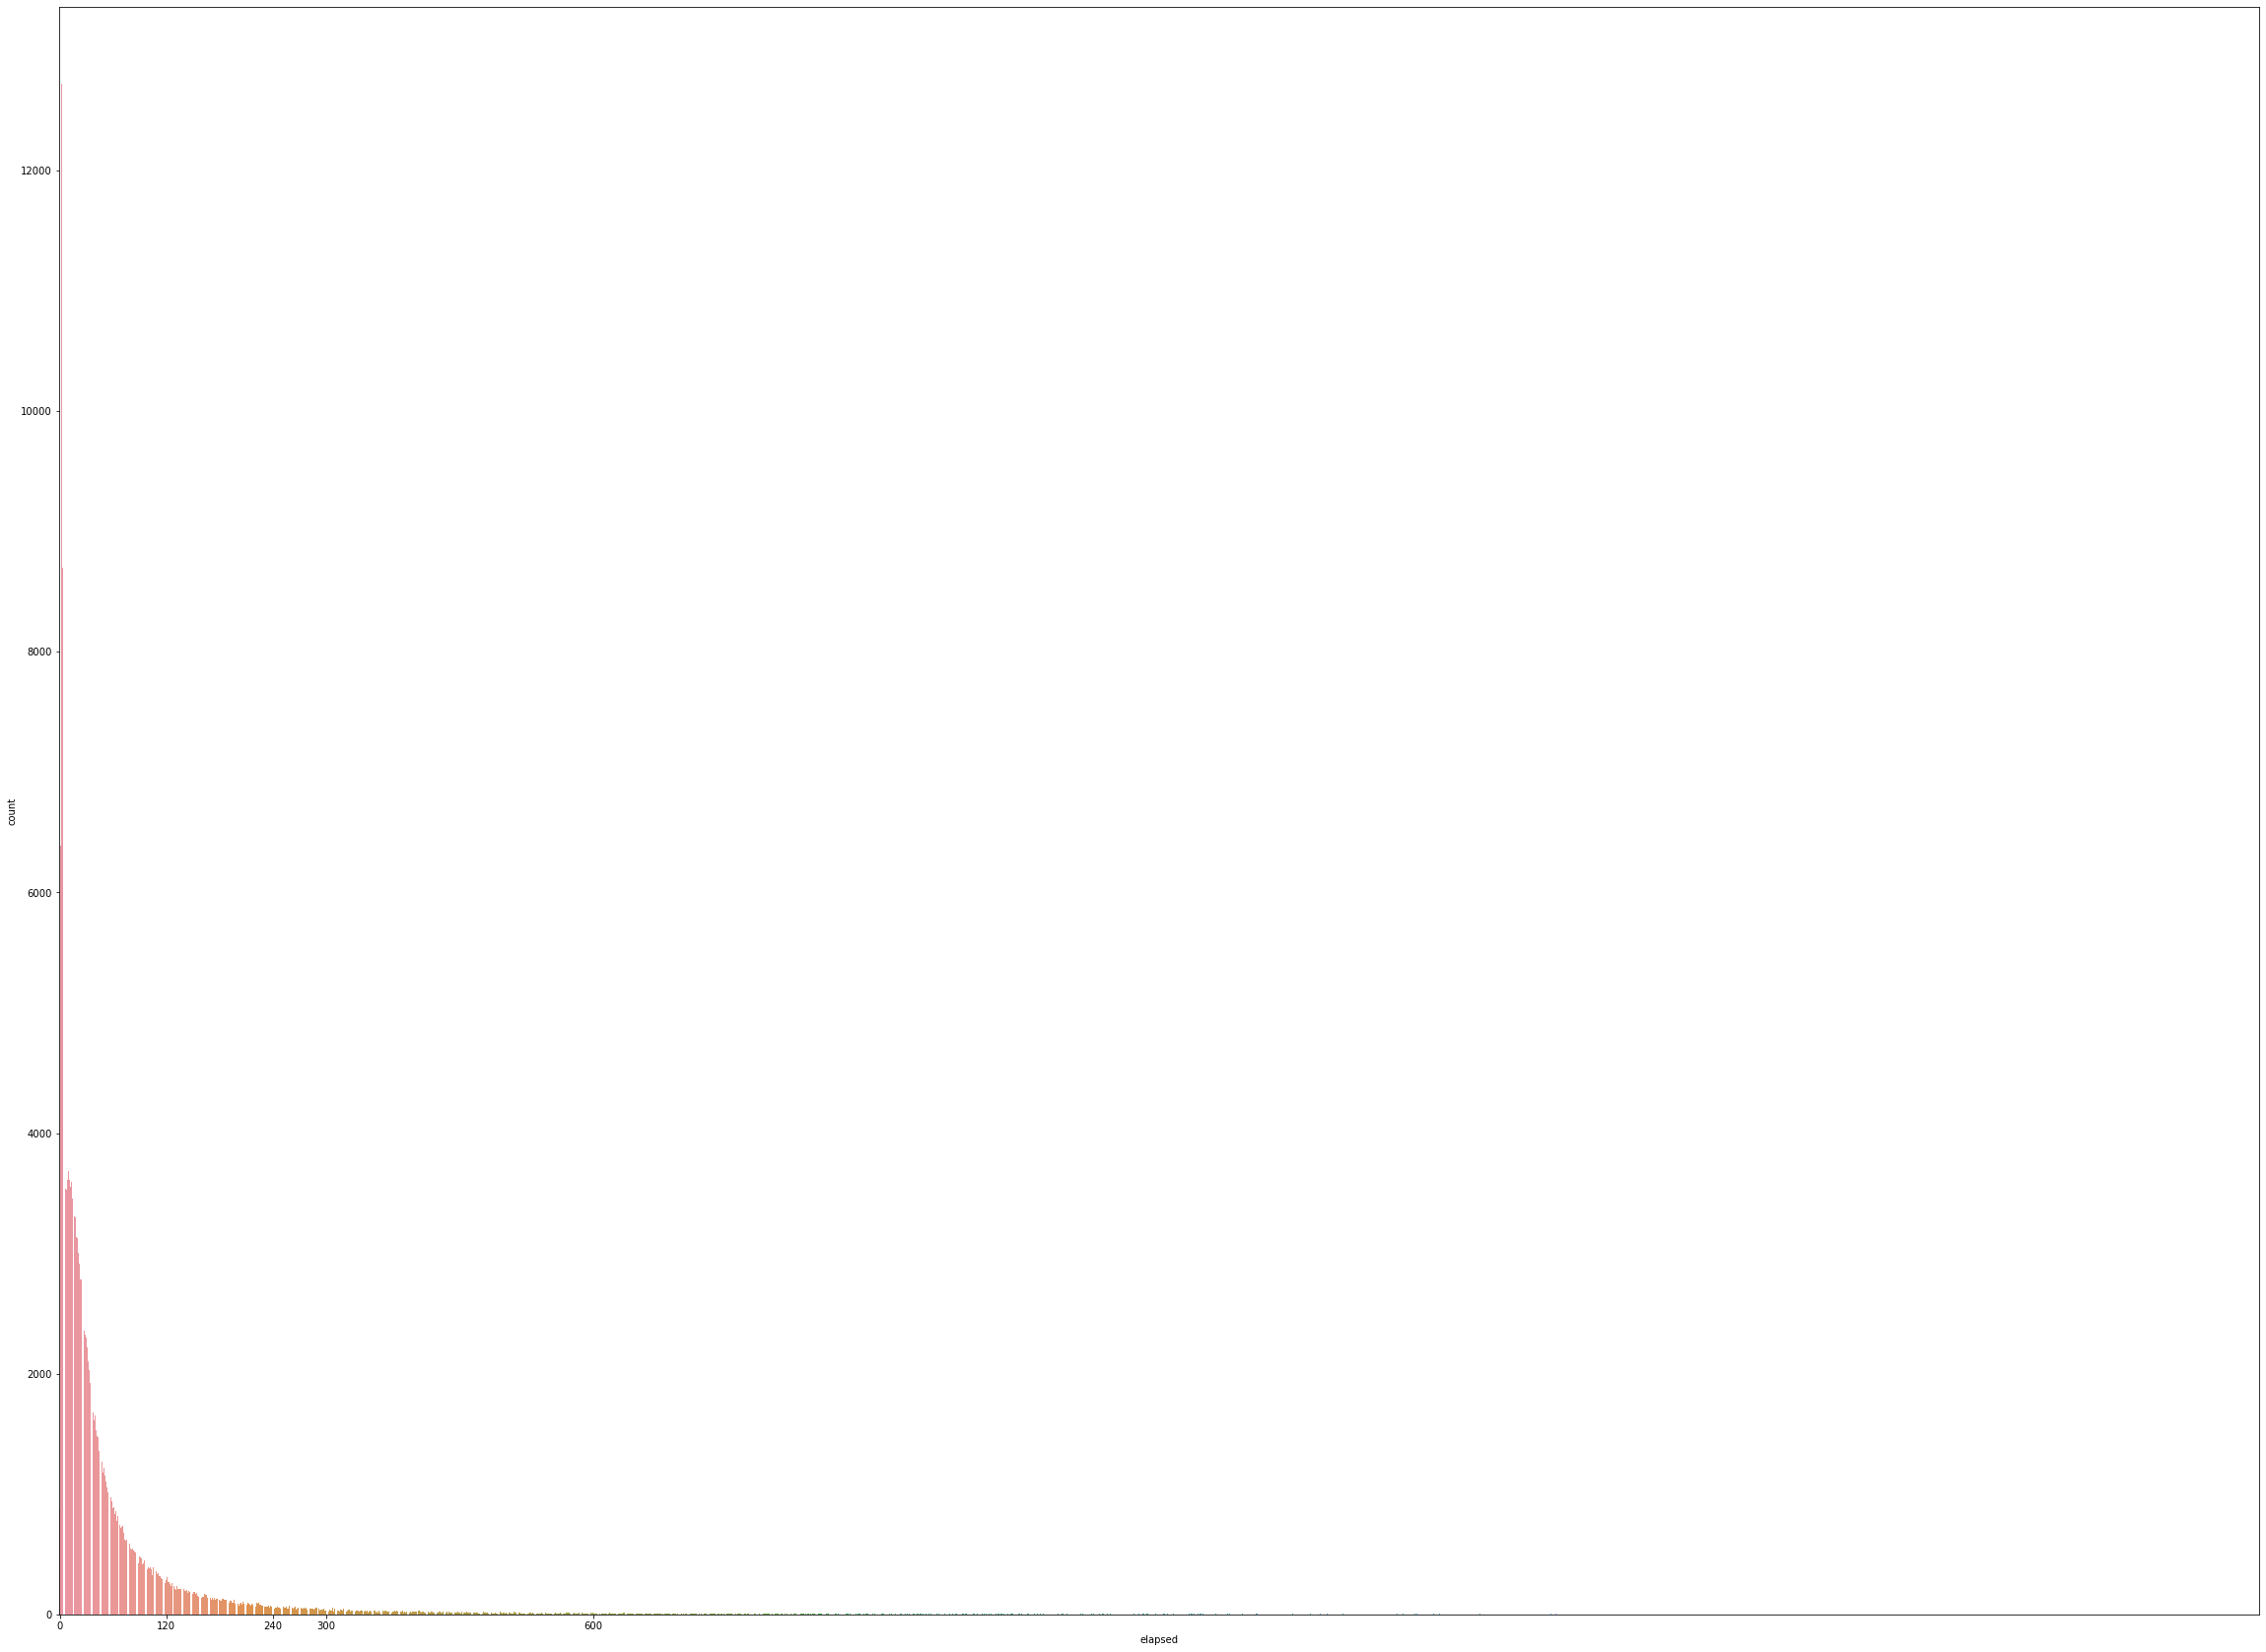

In [390]:
plt.figure(figsize=(40,30))
c = sns.countplot(x='elapsed', data=ttt_drop)
plt.xticks([0,120,240,300,600])

### 7) 대분류 추가

In [142]:
minus_df['big_cate'] = minus_df['testId'].str[2]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 8) 시험지별 -> 점수, 시간

### 9) 정답률 - 전체, 누적